In [5]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
DATA_DIR = "animal_dataset"  
IMG_SIZE = (32, 32)

def load_images():
    X = []
    y = []
    class_names = sorted(os.listdir(DATA_DIR))
    class_map = {
        c: i for i, c in enumerate(class_names)
        }

    for cls in class_names:
        cls_path = os.path.join(DATA_DIR, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)

            try:
                img = Image.open(img_path).convert("L")
                img = img.resize(IMG_SIZE)
                arr = np.array(img).astype(np.float32) / 255.0
                X.append(arr.flatten())
                y.append(class_map[cls])
            except:
                pass

    return np.array(X), np.array(y), class_names

X, y, class_names = load_images()
N = len(X)
print("Total images:", N)
print("Classes:", class_names)

Total images: 300
Classes: ['cat', 'dog', 'panda']


In [7]:
def create_folds(X, y, k=5):
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    fold_size = len(X) // k
    folds = []

    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size
        folds.append(indices[start:end])

    return folds

folds = create_folds(X, y, 5)

In [8]:

def manhattan_dist(a, b):
    return np.sum(np.abs(a - b))

def euclidean_dist(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [9]:
def knn_predict(x, X_train, y_train, K, dist_type):
    dists = []

    for i in range(len(X_train)):
        if dist_type == "L1":
            d = manhattan_dist(x, X_train[i])
        else:
            d = euclidean_dist(x, X_train[i])
        dists.append((d, y_train[i]))

    # sort by distance
    dists.sort(key=lambda x: x[0])

    # take top K labels
    neighbors = [label for (_, label) in dists[:K]]

    # majority vote
    return max(set(neighbors), key=neighbors.count)

In [10]:
def run_5fold(X, y, Ks, dist_type):
    acc_list = []

    for K in Ks:
        fold_accs = []

        for i in range(5):
            val_idx = folds[i]
            train_idx = np.hstack([folds[j] for j in range(5) if j != i])

            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            correct = 0

            for j in range(len(X_val)):
                pred = knn_predict(X_val[j], X_train, y_train, K, dist_type)
                if pred == y_val[j]:
                    correct += 1

            fold_accs.append(correct / len(X_val))

        acc_list.append(np.mean(fold_accs))
        print(f"Dist={dist_type}, K={K}, Acc={acc_list[-1]:.4f}")

    return acc_list

Ks = [1, 3, 5, 7, 9, 11]

print("\nRunning L1 Manhattan CV...")
acc_l1 = run_5fold(X, y, Ks, "L1")

print("\nRunning L2 Euclidean CV...")
acc_l2 = run_5fold(X, y, Ks, "L2")


Running L1 Manhattan CV...
Dist=L1, K=1, Acc=0.3467
Dist=L1, K=3, Acc=0.3600
Dist=L1, K=5, Acc=0.3733
Dist=L1, K=7, Acc=0.4233
Dist=L1, K=9, Acc=0.3867
Dist=L1, K=11, Acc=0.3933

Running L2 Euclidean CV...
Dist=L2, K=1, Acc=0.3300
Dist=L2, K=3, Acc=0.3667
Dist=L2, K=5, Acc=0.3833
Dist=L2, K=7, Acc=0.4067
Dist=L2, K=9, Acc=0.3833
Dist=L2, K=11, Acc=0.4000


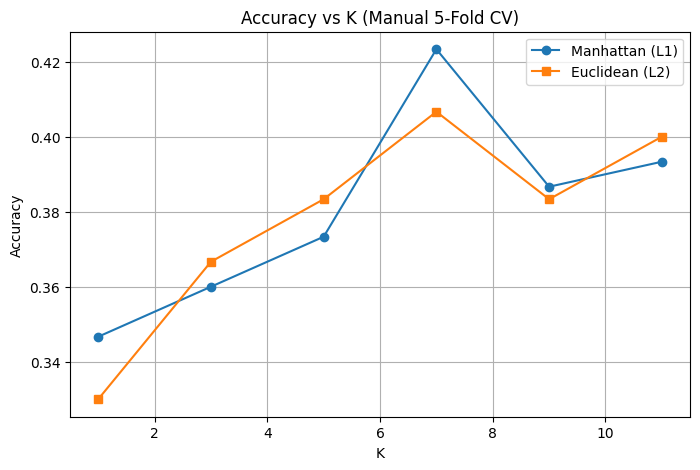

In [11]:
plt.figure(figsize=(8,5))
plt.plot(Ks, acc_l1, marker='o', label="Manhattan (L1)")
plt.plot(Ks, acc_l2, marker='s', label="Euclidean (L2)")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Accuracy vs K (Manual 5-Fold CV)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
best_k = Ks[np.argmax(acc_l2)]
print("\nTraining final model with K =", best_k, "(Euclidean)")

# use 90% train, 10% test 
split = int(0.9 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

print("\nTop 5 predictions:")
for i in range(5):
    pred = knn_predict(X_test[i], X_train, y_train, best_k, "L2")
    print(f"Image {i+1}: Predicted={class_names[pred]}, True={class_names[y_test[i]]}")


Training final model with K = 7 (Euclidean)

Top 5 predictions:
Image 1: Predicted=dog, True=panda
Image 2: Predicted=cat, True=panda
Image 3: Predicted=dog, True=panda
Image 4: Predicted=dog, True=panda
Image 5: Predicted=dog, True=panda
